# Autoencoders

In this notebook, we'll introduce and explore "autoencoders," which are a very successful family of models in modern deep learning. In particular we will:


1.   Illustrate the connection between autoencoders and classical *Principal Component Analysis (PCA)*
3.   Train a non-linear auto-encoder that uses a deep neural network

### Overview
As explained in the text, autoencoders are a way of discovering *latent, low-dimensional structure* in a dataset. In particular, a random data vector $X \in \mathbb{R}^d$ can be said to have low-dimensional structure if we can find some functions $f: \mathbb{R}^d \to \mathbb{R}^k$ and $g: \mathbb{R}^k \to \mathbb{R}^d$, with $k \ll d$, such that $$g(f(X)) \approx X.$$
In other words, $f(X)$ is a parsimonious, $k$-dimensional representation of $X$ that contains all of the information necessary to approximately reconstruct the full vector $X$. Traditionally, $f(X)$ is called an *encoding* of $X$.

It turns out that this is meaningless unless we restrict what kinds of functions $f$ and $g$ are allowed to be, because it's possible to write down some (completely ugly) one-to-one function $\mathbb{R}^d \to \mathbb{R}^1$ for any $d$. This gives rise to the notion of *autoencoders* where, given some sets of reasonable functions $F$ and $G$, we aim to minimize
$$\mathbb{E}[\mathrm{loss}(X, f(g(X))]$$ over functions $f \in F$ and $g \in G$. As usual, this is done by minimizing the sample analog.



## Linear Autoencoders and PCA: Practice

It turns out that linear autoencoders are the same as PCA. Let's do a small sanity check to verify this. In particular, let's perform PCA two ways: first using a standard (linear algebra) toolkit, and second as a linear autoencoder using a neural network library.
If all goes well, they should give you the same reconstructions!

To make it a bit more fun, we will use the [*Labeled Faces in the Wild*](https://www.kaggle.com/jessicali9530/celeba-dataset) dataset which consists of standardized images of roughly 5,000 celebrities' faces. In this data, PCA amounts to looking for a small number of "proto-faces" such that a linear combination of them can accurately reconstruct any celebrity's face.

In [1]:
# First, let's download and inspect the data!
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()

# 3D Array "faces.images" contains images as 2d arrays, stacked along dimension 0
n_examples, height, width = faces.images.shape

# 2D Array "design_matrix" encodes each image as a 1d numeric row, as is conventional in statistics
design_matrix = faces.images.reshape((n_examples, -1))

n_features = design_matrix.shape[1]

print(
    "Labeled Faces in the Wild Dataset: \n\
    Number of examples: {}\n\
    Number of features: {}\n\
    Image height: {}\n\
    Image width: {}".format(
        n_examples,
        n_features,   # per image
        height,
        width))

Labeled Faces in the Wild Dataset: 
    Number of examples: 13233
    Number of features: 2914
    Image height: 62
    Image width: 47


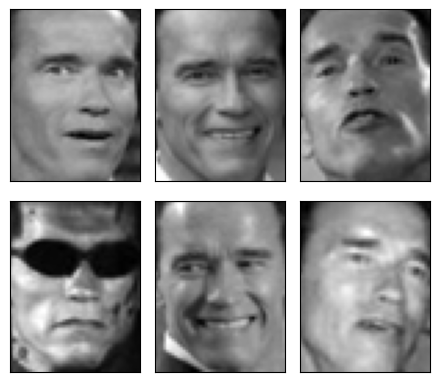

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Let's gather all the images corresponding to Arnold Scwarzenegger to use as examples

# Make a list (of length one!) of labels corresponding to Arnold
# Array "faces.target_names" tells us which numeric label (index) corresponds to which person name (value)
arnold_labels = np.where(faces.target_names == 'Arnold Schwarzenegger')

# Get indices of all images corresponding to this label
# Array "faces.target" tells us which image (index) corresponds to which numeric image labels (value)
arnold_pics = np.where(np.isin(faces.target, arnold_labels))[0]


# Make a helper function so we can take a look at our target images
def plot_faces(images, n_row=2, n_col=3):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()


# Let's try it out!
plot_faces(
    faces.images[arnold_pics[:6], :, :]  # first six images of Arnold appearing in the dataset
)

In [3]:
# 1. Find the first 32 principal components of the dataset using the Scikit-learn library
# For extra fun, you can do so directly using the singular value decomposition (your mileage may vary!)

# We'll use a standard library, which uses linear algebra to compute the principal components.
from sklearn.decomposition import PCA

# There's no need to de-mean the data. Can you explain why?
pca = PCA(n_components=128, svd_solver='randomized').fit(design_matrix)
# out of 2914 eigenvectors, we pick the 128 associated to the biggest eigenvalues

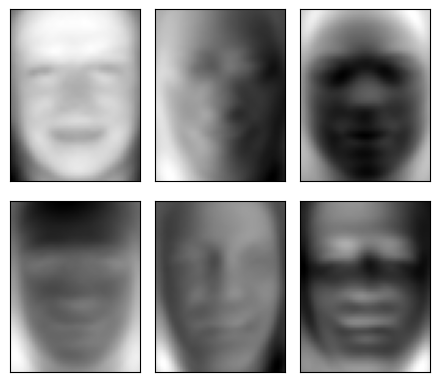

In [4]:
# 2. Plot the first 6 "eigenfaces," the six images whose linear span best explains the variation in our dataset
eigenfaces = pca.components_
plot_faces(eigenfaces[:6])
# we check the first six eigenvectors/projection axes, reshaped
# (the eigenvectors that captured the highest variation in our dataset of images)
# here, eigenvector1 orthog to eigenvector2 and all the others => decorrelation
# (there's no way to reconstruct eigenvector1 using a linear combination of all the other eigenvectors)

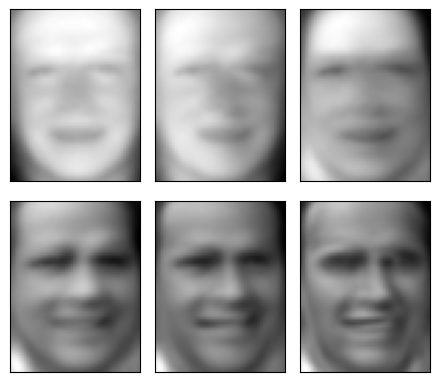

In [5]:
# 3. Plot Arnold's face (any image will do!) reconstructed using 1, 2, 8, 32, 64, 128 principal components
face_vector = design_matrix[arnold_pics[1]]


def reconstruct(image_vector, n_components):
    return eigenfaces[:n_components].T @ (eigenfaces[:n_components] @ image_vector.reshape((-1, 1)))


reconstructions = [reconstruct(face_vector, k) for k in [1, 2, 8, 32, 64, 128]]
plot_faces(reconstructions, n_row=2, n_col=3)

In [6]:
# 4. Train linear autoencoder with 64 neurons using Keras
# 5. Compare reconstructions of Arnold's face both using MSE and visually

In [7]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

encoding_dimension = 64
input_image = Input(shape=(n_features,))
encoded = Dense(encoding_dimension, activation='linear')(input_image)
decoded = Dense(n_features, activation='linear')(encoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


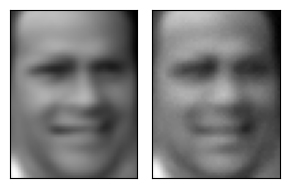

np.float32(9.007769e-09)

In [9]:
# Compute neural reconstruction
reconstruction = autoencoder.predict(face_vector.reshape(1, -1))

# Do visual comparison
plot_faces([reconstructions[4], reconstruction], n_row=1, n_col=2)

# Do numeric comparison
# We also normalize the black/white gradient to take values in [0,1] (divide by 255)
np.mean(np.power((reconstructions[4].T - reconstruction) / 255, 2))

## Neural Autoencoders

Finally, let's train a nonlinear autoencoder for the same data where $F$ and $G$ are neural networks, and we restrict the dimension to be $k=64$.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


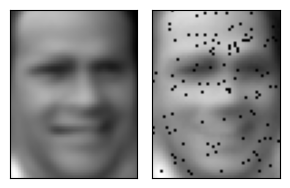

np.float32(1.8106385e-07)

In [10]:
# Use a nonlinear neural network
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense

input_image = Input(shape=(n_features,))
encoded = Dense(64, activation='relu')(input_image)
encoded = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(n_features, activation='relu')(decoded)

autoencoder = Model(input_image, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(design_matrix, design_matrix,
                epochs=50,
                batch_size=256,
                shuffle=True,
                verbose=0)

# Compute neural reconstruction
reconstruction = autoencoder.predict(face_vector.reshape(1, -1))

# Do visual comparison
plot_faces([reconstructions[4], reconstruction], n_row=1, n_col=2)

# Do numeric comparison
# We also normalize the black/white gradient to take values in [0,1] (divide by 255)
np.mean(np.power((reconstructions[4].T - reconstruction) / 255, 2))